# Symmetry protected Topological (SPT) states in graphene

*Topological Phases in Graphene Nanoribbons: Junction States, Spin Centers, and Quantum Spin Chains*, Ting Cao, Fangzhou Zhao, and Steven G. Louie, PRL 2017

In [1]:
# We'll have 3D plotting and 2D band structure, so we need a handful of helper functions.

%run matplotlib_setup.ipy

from types import SimpleNamespace

from ipywidgets import interact
import matplotlib
from matplotlib import pyplot
from mpl_toolkits import mplot3d
import numpy as np
import scipy.linalg as la 

import kwant
from kwant.wraparound import wraparound, plot_2d_bands


def momentum_to_lattice(k):
    """Transform momentum to the basis of reciprocal lattice vectors.
    
    See https://en.wikipedia.org/wiki/Reciprocal_lattice#Generalization_of_a_dual_lattice
    """
    B = np.array(graphene.prim_vecs).T
    A = B.dot(np.linalg.inv(B.T.dot(B)))
    return np.linalg.solve(A, k)


def dispersion_2D(syst, args=None, lim=1.5*np.pi, num_points=200):
    """A simple plot of 2D band structure."""
    if args is None:
        args = []
    momenta = np.linspace(-lim, lim, num_points)
    energies = []
    for kx in momenta:
        for ky in momenta:
            lattice_k = momentum_to_lattice([kx, ky])
            h = syst.hamiltonian_submatrix(args=(list(args) + list(lattice_k)))
            energies.append(np.linalg.eigvalsh(h))
    
    energies = np.array(energies).reshape(num_points, num_points, -1)
    emin, emax = np.min(energies), np.max(energies)
    kx, ky = np.meshgrid(momenta, momenta)
    fig = pyplot.figure()
    axes = fig.add_subplot(1, 1, 1, projection='3d')
    for band in range(energies.shape[-1]):
        axes.plot_surface(kx, ky, energies[:, :, band], cstride=2, rstride=2,
                          cmap=matplotlib.cm.RdBu_r, vmin=emin, vmax=emax,
                          linewidth=0.1)

# Graphene

![](imag/g3.png)

First let us compute the dispersion of pristine periodic graphene 

In [2]:
graphene = kwant.lattice.general([[np.sqrt(3)/2,1/2],[np.sqrt(3)/2,-1/2]],  #Lattice vectors 
                                  [[0,0],[1/np.sqrt(3),0]]) # Co-ordinates
a,b = graphene.sublattices

In [3]:
#Some helper functions to make the schematic look neat
def family_color(site): 
    if site.family == a: 
        return 0 
    else: 
        return 1
    
def hopping_lw(site1,site2): 
    return 0.1 if A in [site1.family,site2.family] else 0.05

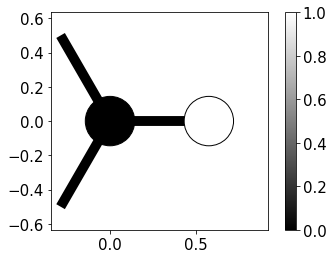

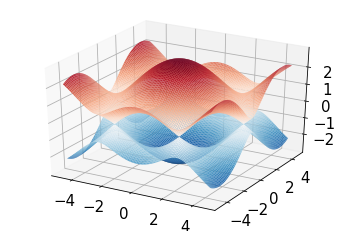

In [4]:
bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
bulk_graphene[graphene.shape((lambda pos: True), (0, 0))] = 0
bulk_graphene[graphene.neighbors(1)] = 1
kwant.plot(bulk_graphene,site_color=family_color,site_lw=0.01)
dispersion_2D(wraparound(bulk_graphene).finalized())

We observe zero band gap with dirac cones at kx = ky =0

Now let us construct nanoribbons with different edge terminations discussed in S. G. Louie PRL 2017

In [9]:
Zigzag = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]], #Lattice vectors
                                     [[1/6,0],[2/6,np.sqrt(3)/2],[4/6,np.sqrt(3)/2],[5/6,0]]) # Coordinates
a,b,c,d = [0,0,0,0]

### *Note that the basis positions specified here are in carteisian co-ordinated and NOT in the reduced lattice vector coordinates*

### Zigzag N = 7 (Z2 = 1)

In [10]:
def get_width(N): 
    if N < 2: 
        raise("N cannot be less than 2")
    else:
        return N/2*Zigzag.prim_vecs[1][1]+0.001

def make_zigzag_ribbon(N=7, L = 20):
    """Returns a zigzag terminated (along -x direction) nanoribbon 
    with length L and width of N carbon atoms
    
    Parameters: 
    ========== 
    
    N = Number of C atoms (width)
    L = Length of the nanoribbon along -x direction 
    
    Returns: 
    =======  
    Instance of kwant.Builder() with the desired nanoribbon geometery 
    """
    
    Zigzag = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]],      #Lattice vectors
                                    [[1/6,0],[2/6,np.sqrt(3)/2],  # Coordinates
                                    [4/6,np.sqrt(3)/2],[5/6,0]]) 
    Z_ribbon = kwant.Builder()
    

    
    Z_ribbon[Zigzag.shape((lambda pos: pos[1] > 0 and pos[1]< get_width(N) 
                           and pos[0] > 0 and pos[0] < L), (0,0))] = 1 
    Z_ribbon[Zigzag.neighbors()] = -1 
    return Z_ribbon 

from ipywidgets import interact
def plot_wf(syst,i_start,i_end,ham):
    """Plot the wave function mapping on system with Hamiltonian 
    "ham" in a PyWidget starting from band index i_start and 
    ending at i_end"""
    eig_val,eig_vec = la.eigh(ham)
    def plot_band(i=0): 
        print("Plotting wave function with index",i)
        print("Energy of the corresponding mode",eig_val[i], "x t")
        fig = kwant.plotter.map(syst,abs(eig_vec[:,i])**2,oversampling=50)
        fig.savefig('figures/%s.jpg'%i,dpi=400,quality=100,transparent=True)
    
    interact(plot_band,i=(i_start,i_end))

Number of bands(sites) in Z7 is 280


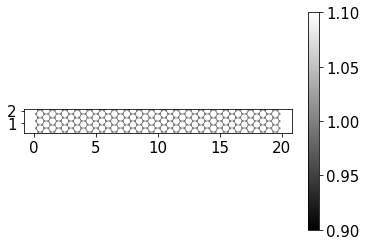

In [11]:
Z7 = make_zigzag_ribbon(N=7)
nbands = len(Z7.sites())
print("Number of bands(sites) in Z7 is",nbands)
fig = kwant.plot(Z7,site_color=family_color,site_lw=0.01);
fig.savefig("test.jpg",dpi=400,quality=100,transparent=True)
Z7 = Z7.finalized()

Protected edge states occur in between the valence and conduction band. Since we expect around 140 valence and 140 conduction bands, let us look at modes with indices from 135 to 145 

In [12]:
ham = Z7.hamiltonian_submatrix()
fig = plot_wf(Z7,138,142,ham)

interactive(children=(IntSlider(value=138, description='i', max=142, min=138), Output()), _dom_classes=('widge…

As expected we find 2 protected edge states at 139th and 140th mode

### Zigzag N = 9 (Z2=1)

Number of bands(sites) in Z9 is 360


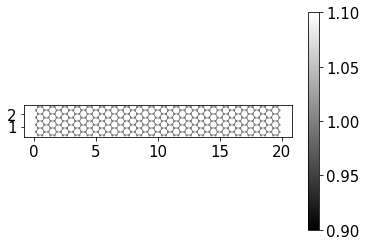

interactive(children=(IntSlider(value=175, description='i', max=185, min=175), Output()), _dom_classes=('widge…

In [9]:
Z9 = make_zigzag_ribbon(N=9)
nbands = len(Z9.sites())
print("Number of bands(sites) in Z9 is",nbands)
kwant.plot(Z9,site_color=family_color,site_lw=0.01);
Z9 = Z9.finalized()
ham = Z9.hamiltonian_submatrix()
plot_wf(Z9,175,185,ham)

### Zigzag N=11 (Z2=0)

Number of bands(sites) in Z11 is 440


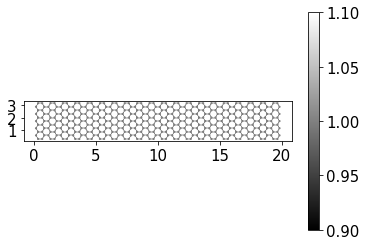

interactive(children=(IntSlider(value=215, description='i', max=225, min=215), Output()), _dom_classes=('widge…

In [10]:
Z11 = make_zigzag_ribbon(N=11)
nbands = len(Z11.sites())
print("Number of bands(sites) in Z11 is",nbands)
kwant.plot(Z11,site_color=family_color,site_lw=0.01);
Z11 = Z11.finalized()
ham = Z11.hamiltonian_submatrix()
plot_wf(Z11,215,225,ham)

***Doubt: Why are there edge modes? (Z2 = 0 accroding to Louie)*** 

### Zigzag N = 8 (Z2 =0) 

Number of bands(sites) in Z11 is 320


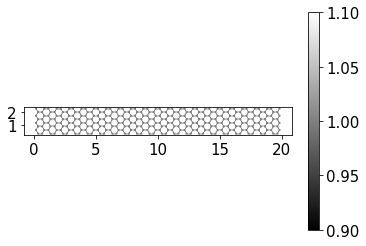

interactive(children=(IntSlider(value=155, description='i', max=165, min=155), Output()), _dom_classes=('widge…

In [11]:
Z8 = make_zigzag_ribbon(N=8)
nbands = len(Z8.sites())
print("Number of bands(sites) in Z11 is",nbands)
kwant.plot(Z8,site_color=family_color,site_lw=0.01);
Z8 = Z8.finalized()
ham = Z8.hamiltonian_submatrix()
plot_wf(Z8,155,165,ham)

## Differentiating surface states from edge modes 

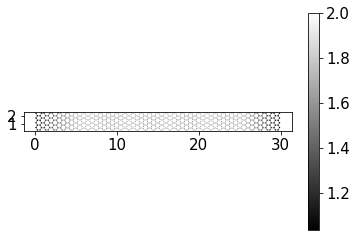

Number of bands(sites) in Z11 is 480


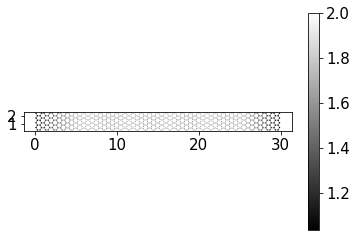

In [12]:
def onsite(site):
    x,y = site.pos
    if x < 5: 
        return 2-1/5*(5-x)
    elif x > 25: 
        return 2-1/5*(x-25)
    else: 
        return 2

def make_zigzag_ribbon_well(N=7, L = 30):
    """Returns a zigzag terminated (along -x direction) nanoribbon 
    with length L and width of N carbon atoms
    
    Parameters: 
    ========== 
    
    N = Number of C atoms (width)
    L = Length of the nanoribbon along -x direction 
    
    Returns: 
    =======  
    Instance of kwant.Builder() with the desired nanoribbon geometery 
    """
    
    Zigzag = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]],      #Lattice vectors
                                    [[1/6,0],[2/6,np.sqrt(3)/2],  # Coordinates
                                    [4/6,np.sqrt(3)/2],[5/6,0]]) 
    Z_ribbon = kwant.Builder()
    

    
    
    Z_ribbon[Zigzag.shape((lambda pos: pos[1] > 0 and pos[1]< get_width(N) 
                           and pos[0] > 0 and pos[0] < L), (0,0))] = onsite 
    Z_ribbon[Zigzag.neighbors()] = -1 
    return Z_ribbon 

N=8
L=30
Z_term = make_zigzag_ribbon_well(N=N,L=L)
kwant.plot(Z_term,site_color=onsite,site_lw=0.01);
nbands = len(Z_term.sites())
print("Number of bands(sites) in Z11 is",nbands)
kwant.plot(Z_term,site_color=onsite,site_lw=0.01);
Z_term = Z_term.finalized()

In [13]:
ham = Z_term.hamiltonian_submatrix()
plot_wf(Z_term,225,255,ham)

interactive(children=(IntSlider(value=225, description='i', max=255, min=225), Output()), _dom_classes=('widge…

Topologically proctected surface states are modes that exists on both the ends simultaneously. Whereas the edge modes occuring due to unsaturated bonds are localized only in one end and each mode corresponds to a side

Let's apply an electric field and see what happens to the symmetry protected topological edge states

# N=7 with electric field

In [14]:
def make_zigzag_ribbon_efield(N=7, L = 30):
    """Returns a zigzag terminated (along -x direction) nanoribbon 
    with length L and width of N carbon atoms
    
    Parameters: 
    ========== 
    
    N = Number of C atoms (width)
    L = Length of the nanoribbon along -x direction 
    
    Returns: 
    =======  
    Instance of kwant.Builder() with the desired nanoribbon geometery 
    """
    def onsite(site):
        x,y = site.pos
        return 0.1*(L-x)/L

    Zigzag = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]],      #Lattice vectors
                                    [[1/6,0],[2/6,np.sqrt(3)/2],  # Coordinates
                                    [4/6,np.sqrt(3)/2],[5/6,0]]) 
    Z_ribbon = kwant.Builder()
    
    def get_width(N): 
        if N < 2: 
            raise("N cannot be less than 2")
        else:
            return N/2*Zigzag.prim_vecs[1][1]+0.001

    
    Z_ribbon[Zigzag.shape((lambda pos: pos[1] > 0 and pos[1]< get_width(N) 
                           and pos[0] > 0 and pos[0] < L), (0,0))] = onsite
    Z_ribbon[Zigzag.neighbors()] = 1 
    return Z_ribbon 

Number of bands(sites) in Z7_efield is 420


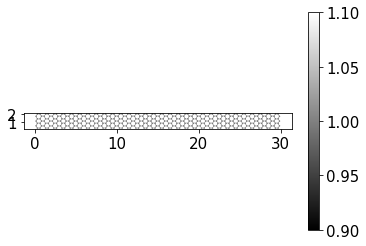

In [15]:
Z7_efield = make_zigzag_ribbon_efield(N=7)
nbands = len(Z7_efield.sites())
print("Number of bands(sites) in Z7_efield is",nbands)
kwant.plot(Z7_efield,site_color=family_color,site_lw=0.01);
Z7_efield = Z7_efield.finalized()

In [16]:
ham = Z7_efield.hamiltonian_submatrix()
plot_wf(Z7_efield,200,220,ham)

interactive(children=(IntSlider(value=200, description='i', max=220, min=200), Output()), _dom_classes=('widge…

# N=8 with electric field 

Number of bands(sites) in Z8_efield is 480


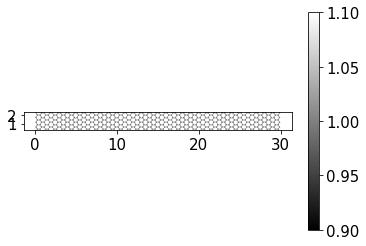

In [17]:
Z8_efield = make_zigzag_ribbon_efield(N=8)
nbands = len(Z8_efield.sites())
print("Number of bands(sites) in Z8_efield is",nbands)
kwant.plot(Z8_efield,site_color=family_color,site_lw=0.01);
Z8_efield = Z8_efield.finalized()

In [ ]:
ham = Z8_efield.hamiltonian_submatrix()
plot_wf(Z8_efield,230,250,ham)